<a href="https://colab.research.google.com/github/jeonggunlee/Vision-Transformer-Study/blob/main/Vision_Transformer_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Vision-Transformers with CIFAR10

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/state/partition1/job-16861214/ipykernel_3820894/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# -*- coding: utf-8 -*-
'''
Train CIFAR10 with PyTorch and Vision Transformers!
written by @kentaroy47, @arutema47
'''

from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import pandas as pd
import csv

#from models import *
#from models.vit import ViT
#from utils import progress_bar

In [3]:
# !pip install einops
# !pip install odach

In [4]:
# -*- coding: utf-8 -*-

'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


try:
	_, term_width = os.popen('stty size', 'r').read().split()
except:
	term_width = 80
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

stty: 'standard input': Inappropriate ioctl for device


In [5]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py

from einops import rearrange


MIN_NUM_PATCHES = 16

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

        # MASK HERE
    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        
        
        
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        
        
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask = None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        
        
        
        
        x = self.patch_to_embedding(x)
        
        
        
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [5]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [6]:
lr=1e-4 # learning rate. for resnets.. 1e-3, Vit..1e-4?
opt="adam"
resume= 0  # resume from checkpoin
aug=!      # add image augumentations
mixup=1    # add mixup augumentations
#net=vit
bs=64
n_epochs=100
patch=4
cos=0      # Train with cosine annealing scheduling

if cos:
    from warmup_scheduler import GradualWarmupScheduler
if aug:
    import albumentations

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified


/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


# Testing Original Embedding

In [8]:
batch0 = next(iter(trainloader))

In [9]:
images, labels = batch0[0], batch0[1]

In [10]:
image, label = batch0[0][0], batch0[1][0]

In [11]:
image.size()

torch.Size([3, 32, 32])

In [27]:
image

tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-1.1497, -0.6650, -1.2660,  ..., -0.8977, -2.4291, -2.4291],
         [-0.9752, -0.6069, -1.3241,  ..., -1.8087, -2.4291, -2.4291],
         ...,
         [-1.6731, -1.7118, -1.6924,  ..., -2.1964, -2.4291, -2.4291],
         [-1.6731, -1.6149, -1.6343,  ..., -2.2546, -2.4291, -2.4291],
         [-1.6537, -1.6149, -1.6149,  ..., -2.3321, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-0.8646, -0.3532, -0.7662,  ..., -0.7859, -2.4183, -2.4183],
         [-0.5892, -0.2549, -0.9236,  ..., -1.6512, -2.4183, -2.4183],
         ...,
         [-1.0612, -1.1792, -1.1989,  ..., -1.7496, -2.4183, -2.4183],
         [-1.0416, -1.0416, -1.1399,  ..., -1.8676, -2.4183, -2.4183],
         [-1.0612, -0.9629, -1.0416,  ..., -1.9659, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-0.5045,  0.0028, -0.4655,  ..., -1

In [62]:
image_size = 32
patch_size = 4
num_classes = 10
channels = 3
dim = 512
depth = 6
heads = 8
mlp_dim = 512
dropout_prob = 0.1
emb_dropout = 0.1

### ViT

In [32]:
assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
num_patches = (image_size // patch_size) ** 2
patch_dim = channels * patch_size ** 2
assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

In [33]:
num_patches

64

In [34]:
patch_dim

48

In [38]:
pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

In [41]:
pos_embedding.size() # 65 because we need to account for extra cls token to be prepended

torch.Size([1, 65, 512])

In [42]:
patch_to_embedding = nn.Linear(patch_dim, dim)

In [53]:
print(patch_to_embedding)

Linear(in_features=48, out_features=512, bias=True)


In [54]:
cls_token = nn.Parameter(torch.randn(1, 1, dim))

In [55]:
cls_token.size()

torch.Size([1, 1, 512])

In [57]:
dropout = nn.Dropout(emb_dropout)

In [58]:
print(dropout)

Dropout(p=0.1, inplace=False)


In [63]:
transformer = Transformer(dim, depth, heads, mlp_dim, dropout=dropout_prob)

In [64]:
print(transformer)

Transformer(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=512, out_features=512, bias=True)
              (4): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
    )
    (1): ModuleList(
      (0

In [65]:
to_cls_token = nn.Identity()

In [66]:
to_cls_token

Identity()

In [68]:
mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(mlp_dim, num_classes)
        )

In [69]:
mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): GELU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=True)
)

## Forward

In [71]:
p = patch_size
p

4

In [75]:
images.size()

torch.Size([64, 3, 32, 32])

In [76]:
x = rearrange(images, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p) # get in form of (batch x num_patches x flattened_patch * num_channels)

In [77]:
x.size()

torch.Size([64, 64, 48])

In [83]:
(32*32*3)/64

48.0

In [84]:
x = patch_to_embedding(x) # pass through linear layer, proj 48 -> 512

In [85]:
x.size()

torch.Size([64, 64, 512])

In [89]:
b, n, _ = x.shape

In [92]:
b, n, _

(64, 64, 512)

In [93]:
cls_tokens = cls_token.expand(b, -1, -1) # broadcast cls token to length of one patch_embeddings, batch_size number of times

In [94]:
cls_tokens.size()

torch.Size([64, 1, 512])

In [95]:
x = torch.cat((cls_tokens, x), dim=1) # prepend cls token to embedded image, KEEP IN MIND THIS IS DONE FOR EACH IMAGE IN THE BATCH (FIRST INDEX)

In [96]:
x.size()

torch.Size([64, 65, 512])

In [97]:
pos_embedding[:, :(n + 1)].size()

torch.Size([1, 65, 512])

In [98]:
x += pos_embedding[:, :(n + 1)] # elementwise-add positional embedding to patch embedding

In [99]:
x.size()

torch.Size([64, 65, 512])

In [100]:
x = dropout(x)

In [101]:
x.size()

torch.Size([64, 65, 512])

In [102]:
mask = None

In [103]:
x = transformer(x, mask)

In [104]:
x.size()

torch.Size([64, 65, 512])

In [105]:
to_cls_token

Identity()

In [107]:
to_cls_token(x[:, 0]).size()

torch.Size([64, 512])

In [108]:
x = to_cls_token(x[:, 0])

In [109]:
x.size()

torch.Size([64, 512])

In [110]:
mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): GELU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=True)
)

In [111]:
out = mlp_head(x)

In [112]:
out.size() # project back to num_classes

torch.Size([64, 10])

# Testing Super-Pixel Embedding

In [23]:
batch0 = next(iter(trainloader))

In [74]:
images, labels = batch0[0], batch0[1]

In [25]:
image, label = batch0[0][0], batch0[1][0]

In [26]:
image.size()

torch.Size([3, 32, 32])

In [27]:
image

tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-1.1497, -0.6650, -1.2660,  ..., -0.8977, -2.4291, -2.4291],
         [-0.9752, -0.6069, -1.3241,  ..., -1.8087, -2.4291, -2.4291],
         ...,
         [-1.6731, -1.7118, -1.6924,  ..., -2.1964, -2.4291, -2.4291],
         [-1.6731, -1.6149, -1.6343,  ..., -2.2546, -2.4291, -2.4291],
         [-1.6537, -1.6149, -1.6149,  ..., -2.3321, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-0.8646, -0.3532, -0.7662,  ..., -0.7859, -2.4183, -2.4183],
         [-0.5892, -0.2549, -0.9236,  ..., -1.6512, -2.4183, -2.4183],
         ...,
         [-1.0612, -1.1792, -1.1989,  ..., -1.7496, -2.4183, -2.4183],
         [-1.0416, -1.0416, -1.1399,  ..., -1.8676, -2.4183, -2.4183],
         [-1.0612, -0.9629, -1.0416,  ..., -1.9659, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-0.5045,  0.0028, -0.4655,  ..., -1

## Superpixels

In [12]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

In [13]:
image_arr = image.numpy()

In [14]:
type(image_arr)

numpy.ndarray

In [15]:
image_arr.shape

(3, 32, 32)

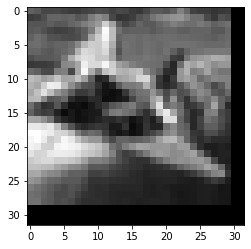

In [16]:
plt.imshow(image.numpy()[0], cmap='gray')
plt.show()

In [17]:
image_arr = np.transpose(image_arr, (1, 2, 0))

In [18]:
image_arr.shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


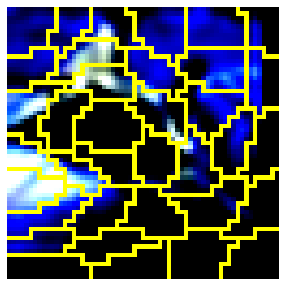

In [50]:
# apply SLIC and extract (approximately) the supplied number
# of segments
numSegments=50


segments = slic(image_arr, 
                n_segments = numSegments, 
                sigma=3, 
                channel_axis=2,
#                 slic_zero=True
               )


# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments), figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

ax.imshow(
    mark_boundaries(image_arr, segments, mode='subpixel')
         )

plt.axis("off")
# show the plots
plt.show()

In [51]:
segments.shape

(32, 32)

In [56]:
np.unique(segments)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [58]:
len(np.unique(segments))

36

In [52]:
len(set(segments.flatten()))

36

In [57]:
segments[5:10, 5:10]

array([[ 8,  2,  7,  7,  7],
       [ 8,  7,  7,  7,  7],
       [ 8,  7,  7,  7, 12],
       [ 7,  7,  7, 12, 12],
       [13, 13, 12, 12, 12]])

In [ ]:
# embedding dimension = channels * patch_size^2

We need to get the tensor in format of (batch_size x num_patches x flattened_patch * num_channels), then pass final index 
through linear layer Linear(idx2, embed_dim)

embed_dim is 512 above

In [62]:
image_size = 32
patch_size = 4
num_classes = 10
channels = 3
dim = 512
depth = 6
heads = 8
mlp_dim = 512
dropout_prob = 0.1
emb_dropout = 0.1

### ViT

In [32]:
assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
num_patches = (image_size // patch_size) ** 2
patch_dim = channels * patch_size ** 2
assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

In [33]:
num_patches

64

In [34]:
patch_dim

48

In [38]:
pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

In [41]:
pos_embedding.size() # 65 because we need to account for extra cls token to be prepended

torch.Size([1, 65, 512])

In [42]:
patch_to_embedding = nn.Linear(patch_dim, dim)

In [53]:
print(patch_to_embedding)

Linear(in_features=48, out_features=512, bias=True)


In [54]:
cls_token = nn.Parameter(torch.randn(1, 1, dim))

In [55]:
cls_token.size()

torch.Size([1, 1, 512])

In [57]:
dropout = nn.Dropout(emb_dropout)

In [58]:
print(dropout)

Dropout(p=0.1, inplace=False)


In [63]:
transformer = Transformer(dim, depth, heads, mlp_dim, dropout=dropout_prob)

In [64]:
print(transformer)

Transformer(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=512, out_features=512, bias=True)
              (4): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
    )
    (1): ModuleList(
      (0

In [65]:
to_cls_token = nn.Identity()

In [66]:
to_cls_token

Identity()

In [68]:
mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(mlp_dim, num_classes)
        )

In [69]:
mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): GELU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=True)
)

In [71]:
p = patch_size
p

4

In [75]:
images.size()

torch.Size([64, 3, 32, 32])

In [76]:
x = rearrange(images, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)

In [77]:
x.size()

torch.Size([64, 64, 48])

In [83]:
(32*32*3)/64

48.0

In [84]:
x = patch_to_embedding(x) # pass through linear layer, proj 48 -> 512

In [85]:
x.size()

torch.Size([64, 64, 512])

In [89]:
b, n, _ = x.shape

In [92]:
b, n, _

(64, 64, 512)

In [93]:
cls_tokens = cls_token.expand(b, -1, -1) # broadcast cls token to length of one patch_embeddings, batch_size number of times

In [94]:
cls_tokens.size()

torch.Size([64, 1, 512])

In [95]:
x = torch.cat((cls_tokens, x), dim=1) # prepend cls token to embedded image, KEEP IN MIND THIS IS DONE FOR EACH IMAGE IN THE BATCH (FIRST INDEX)

In [96]:
x.size()

torch.Size([64, 65, 512])

In [97]:
pos_embedding[:, :(n + 1)].size()

torch.Size([1, 65, 512])

In [98]:
x += pos_embedding[:, :(n + 1)] # elementwise-add positional embedding to patch embedding

In [99]:
x.size()

torch.Size([64, 65, 512])

In [100]:
x = dropout(x)

In [101]:
x.size()

torch.Size([64, 65, 512])

In [102]:
mask = None

In [103]:
x = transformer(x, mask)

In [104]:
x.size()

torch.Size([64, 65, 512])

In [105]:
to_cls_token

Identity()

In [107]:
to_cls_token(x[:, 0]).size()

torch.Size([64, 512])

In [108]:
x = to_cls_token(x[:, 0])

In [109]:
x.size()

torch.Size([64, 512])

In [110]:
mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): GELU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=True)
)

In [111]:
out = mlp_head(x)

In [112]:
out.size() # project back to num_classes

torch.Size([64, 10])

# Continue with Model

In [8]:
# ViT for cifar10
net = ViT(
    image_size = 32,
    patch_size = patch,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [9]:
ls

checkpoint/  jeo_vit_cifar10_imagenet.ipynb  jgl_vit_cifar10.ipynb  log/


In [10]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net) # make parallel
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/{}-ckpt.t7'.format("vit"))
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

# Loss is CE
criterion = nn.CrossEntropyLoss()
# reduce LR on Plateau
if opt == "adam":
    optimizer = optim.Adam(net.parameters(), lr)
elif opt == "sgd":
    optimizer = optim.SGD(net.parameters(), lr)    
if not cos:
    from torch.optim import lr_scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-3*1e-5, factor=0.1)
else:
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)
    

In [11]:
##### Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)


In [12]:
lr=1e-4

In [13]:
##### Validation
import time
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Update scheduler
    if not cos:
        scheduler.step(test_loss)
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+'vit'+'-{}-ckpt.t7'.format(patch))
        best_acc = acc
    
    os.makedirs("log", exist_ok=True)
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, val loss: {test_loss:.5f}, acc: {(acc):.5f}'
    print(content)
    with open(f'log/log_vit.txt', 'a') as appender:
        appender.write(content + "\n")
    return test_loss, acc

list_loss = []
list_acc = []
for epoch in range(start_epoch, n_epochs):
    trainloss = train(epoch)
    val_loss, acc = test(epoch)
    
    if cos:
        scheduler.step(epoch-1)
    
    list_loss.append(val_loss)
    list_acc.append(acc)
    
    # write as csv for analysis
    with open(f'log/log_vit.csv', 'w') as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow(list_loss) 
        writer.writerow(list_acc) 
    print(list_loss)


Epoch: 0
 [================================================================>]  Step: 26ms | Tot: 39s158ms | Train Loss: 1.780 | Train Acc: 34.332% (17166/5000 782/782 02/782 ==============================>..................................]  Step: 51ms | Tot: 18s154ms | Train Loss: 1.950 | Train Acc: 27.050% (6267/2316 362/782 
 [================================================================>]  Step: 24ms | Tot: 3s322ms | Test Loss: 1.529 | Test Acc: 45.550% (4555/1000 100/100 
Saving..
Wed Mar 30 21:53:10 2022 Epoch 0, lr: 0.0001000, val loss: 152.87451, acc: 45.55000
[152.87451028823853]

Epoch: 1


KeyboardInterrupt: 